In [3]:
import os
import clip
import torch
import numpy as np
from PIL import Image
from diffusers import StableDiffusionPipeline
from transformers import BlipProcessor, BlipForConditionalGeneration

2025-04-27 14:59:15.430094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745765955.612640      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745765955.666587      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7ip6qw0f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7ip6qw0f
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Generation of images (stable diffusion)

In [ ]:
#local_path = "/kaggle/input/realistic-vision/pytorch/default/1/realisticVisionV60B1_v51HyperVAE.safetensors"

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda") 

In [4]:
def generate_image_by_caption(caption):
    image = pipe(caption).images[0]
    image = np.array(image)
    image = image/255.
    return image

## Generation of caption for images (Blip)

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda")

In [6]:
def generate_caption(img_path):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(image, return_tensors="pt").to("cuda")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

## Generating images with the captions

In [7]:
images_path = os.listdir("/kaggle/input/flickrfaceshq-dataset-ffhq")
images_path = images_path[:2500]
images_caption = []

for image in images_path:
    path = f"/kaggle/input/flickrfaceshq-dataset-ffhq/{image}"
    caption = generate_caption(path)
    images_caption.append(caption)

In [ ]:
images_caption = images_caption

for num, caption in enumerate(images_caption):
    image = generate_image_by_caption(caption)
    image = (image * 255).astype(np.uint8)
    image = np.squeeze(image)  
    pil_image = Image.fromarray(image)
    pil_image.save(f"Image_{num}.png")

## Saving thoses images on a .zip

In [24]:
import zipfile
import os

folder_path = '/kaggle/working/'
zip_filename = 'imagens_parte1.zip'

# Lista só os primeiros 50 arquivos de imagem
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg'))]

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in image_files:
        zipf.write(os.path.join(folder_path, file), arcname=file)

print(f'{zip_filename} criado com sucesso.')

imagens_parte1.zip criado com sucesso.


## Extraction of features (Clip)

In [4]:
ld_images = os.listdir('/kaggle/input/images-from-latent-diffusion-model')
s_images = os.listdir('/kaggle/input/real-and-fake-images/dataset/train/fake_images')
r_images = os.listdir('/kaggle/input/real-and-fake-images/dataset/train/real_images')

s_images = s_images[:len(ld_images)]
r_images = r_images[:len(ld_images)]

In [5]:
model_clip, preprocess = clip.load("ViT-B/32", device="cuda")

def extrair_features(full_path):
    image = Image.open(full_path).convert("RGB")
    image = preprocess(image).unsqueeze(0).to("cuda")
    with torch.no_grad():
        feature = model_clip.encode_image(image)
    return feature.cpu().numpy().flatten()


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 137MiB/s]


In [6]:
images_path = (
    [f"/kaggle/input/images-from-latent-diffusion-model/{img}" for img in ld_images] +
    [f"/kaggle/input/real-and-fake-images/dataset/train/fake_images/{img}" for img in s_images] +
    [f"/kaggle/input/real-and-fake-images/dataset/train/real_images/{img}" for img in r_images]
)

features = [extrair_features(path) for path in images_path]

In [7]:
labels = list(np.zeros(len(ld_images))) + list(np.zeros(len(s_images))) + list(np.ones(len(r_images)))

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [9]:
clf = SVC(kernel='linear', C=1.0)

In [10]:
x_train , x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [11]:
clf.fit(x_train ,y_train)

SVC(kernel='linear')

In [12]:
y_pred = clf.predict(x_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9899497487437185


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       142
         1.0       1.00      0.96      0.98        57

    accuracy                           0.99       199
   macro avg       0.99      0.98      0.99       199
weighted avg       0.99      0.99      0.99       199



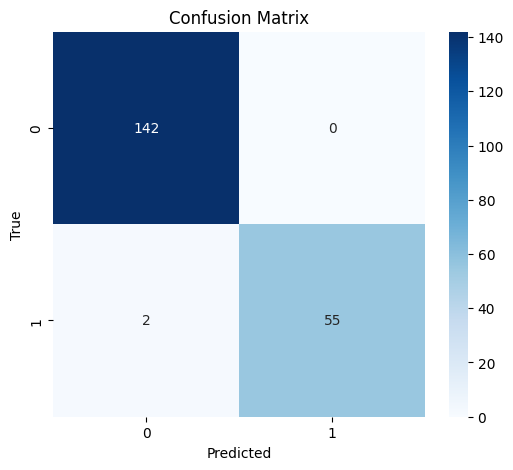

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')  # ou 'macro', 'micro' dependendo do que quiser
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.9901
Recall: 0.9899
F1-score: 0.9899


In [88]:
import pickle

filename = 'svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf, file)